In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_ode, plot_losses, rmse
from modules.problems import LotkaVolterra

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=1000, print_every=1000
):
    collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)

        L = w1 * L_I + w2 * L_X + w3 * L_Y

        L.backward()
        optimizer.step()
        
        if i % collect_every == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()

            error_x = rmse(x, problem.solution[0])
            error_y = rmse(y, problem.solution[1])

            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            errors.append(np.array([error_x, error_y]))
        
        if i % print_every == 0:
            print(f'Iteration {i} --- {error_x / 2 + error_y / 2}')
    
    return np.array(losses), np.array(errors)

In [ ]:
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 5, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])

plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

In [ ]:
L, W = 6, 48
model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2).to(device)
model.init_weights(init.eye_)

w1, w2, w3 = 0.416562, 1.396133, 1.402344
num_iters = 15000
N_D = 5120
lr = 0.000351
collect_every = 500

losses, errors = train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=collect_every, print_every=1000
)

In [ ]:
preds = model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$', None), (problem.solution[1], r'$y(t)$', None)],
    predicted=[(x, r'$\mathcal{X}(t)$', None), (y, r'$\mathcal{Y}(t)$', None)],
    title='Lotka-Volterra System', size=(5, 3)
)

In [20]:
plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$\mathcal{L_I}$'),
        (losses[:,1], r'$\mathcal{L_X}$'),
        (losses[:,2], r'$\mathcal{L_Y}$'),
        (losses[:,3], r'$\mathcal{L_T}$')
    ],
    errors=[
        (errors[:,0], r'$\mathcal{X}(t)$'),
        (errors[:,1], r'$\mathcal{Y}(t)$')
    ]
)

NameError: name 'losses' is not defined

## Interesting problem statements
---

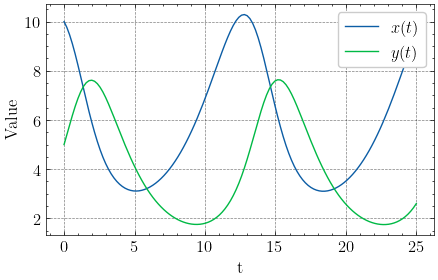

In [5]:
# Default
T = 25
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 10, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

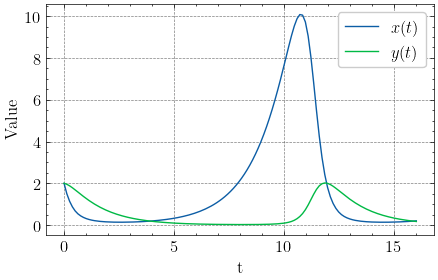

In [101]:
# Pretty sharp solution.
T = 16
alpha, beta, delta, gamma = 0.7, 1.5, 0.3, 0.7
x_0, y_0 = 2, 2
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

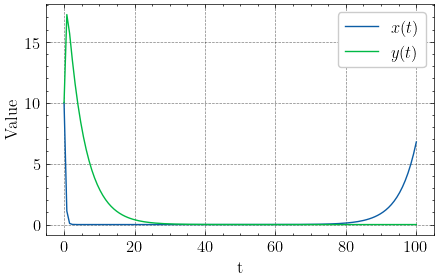

In [90]:
# This solution is exhibit pretty usual behavior for L-V system.
T = 100
alpha, beta, delta, gamma = 0.2, 0.2, 0.2, 0.2
x_0, y_0 = 10, 10
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

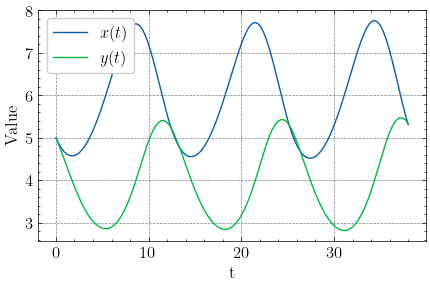

In [62]:
# Default parameters with different initialization and larger time T.
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 5, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

## Hyperparameter tuning
---

In [63]:
import optuna

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
study_name = None
best_model = None
model = None

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 8, step=2)
    W = trial.suggest_int('W', 32, 128, step=32)
    
    model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2).to(device)
    
    init_rule = trial.suggest_categorical('initialization', ['zeros', 'eye', 'normal'])
    if init_rule == 'zeros':
        model.init_weights(init.zeros_)
    elif init_rule == 'eye':
        model.init_weights(init.eye_)
    else: 
        model.init_weights(init.normal_)
    
    N_D = trial.suggest_int('N_D', 512, 1024 * 10, step=512)
    collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)

    lr = trial.suggest_float('lr', 1e-5, 1.0, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    w1 = trial.suggest_float('w1', 0.1, 2.)
    w2 = trial.suggest_float('w2', 0.1, 2.)
    w3 = trial.suggest_float('w3', 0.1, 2.)
    
    preds = model(problem.t.reshape(-1, 1).to(device)).detach().cpu().numpy()
    x = preds[:,0].flatten()
    y = preds[:,1].flatten()

    error = (rmse(x, problem.solution[0]) + rmse(y, problem.solution[1])) / 2

    for i in range(10000):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)

        L = w1 * L_I + w2 * L_X + w3 * L_Y

        L.backward()
        optimizer.step()
        
        if (i + 1) % 1000 == 0:
            preds = model(problem.t.reshape(-1, 1).to(device)).detach().cpu().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()

            new_error = (rmse(x, problem.solution[0]) + rmse(y, problem.solution[1])) / 2
            if np.abs(error - new_error) < 0.01: break
            
            error = new_error
    
    trial.set_user_attr("finished_iterations", i + 1)
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

In [69]:
def get_problem(N):
    match N:
        case 1:
            T = 25
            alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
            x_0, y_0 = 10, 5
            name = 'lv_1'
        case 2:
            T = 16
            alpha, beta, delta, gamma = 0.7, 1.5, 0.3, 0.7
            x_0, y_0 = 2, 2
            name = 'lv_2'
        case 3:
            T = 100
            alpha, beta, delta, gamma = 0.2, 0.2, 0.2, 0.2
            x_0, y_0 = 10, 10
            name = 'lv_3'
        case 4:
            T = 38
            alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
            x_0, y_0 = 5, 5
            name = 'lv_4'
    
    problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
    study = optuna.create_study(study_name=name, direction='minimize')
    return study, problem

Существуют запуски с большим N_D, которые дают плохой результат. 

Значит, не всегда плохой результат является следствием малого количества N_D. 

Скорее он связан с плохим lr и плохой инициализацией. Но что именно это значит?

In [ ]:
for i in range(1,5):
    study, problem = get_problem(i)
    
    study.optimize(objective, n_trials=5, callbacks=[callback])
    study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')
    
    torch.save(best_model, f'./studies/{study.study_name}_best_model.pt')

In [ ]:
preds = best_model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$', None), (problem.solution[1], r'$y(t)$', None)],
    predicted=[(x, r'$\mathcal{X}(t)$', None), (y, r'$\mathcal{Y}(t)$', None)],
    title='Lotka-Volterra System', size=(5, 3)
)

## Hyperparameter analysis
---

In [5]:
import pandas as pd
from modules.utils import get_corr, plot_rmse_corr

In [6]:
new_names = ['rmse', 'L', 'N_D', 'W', 'init', 'lr', 'w1', 'w2', 'w3', 'iters']

lv1 = pd.read_csv('./studies/lv_1.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)
lv2 = pd.read_csv('./studies/lv_2.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)
lv3 = pd.read_csv('./studies/lv_3.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)
lv4 = pd.read_csv('./studies/lv_4.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)

for df in [lv1, lv2, lv3, lv4]:
    df.columns = new_names

[]

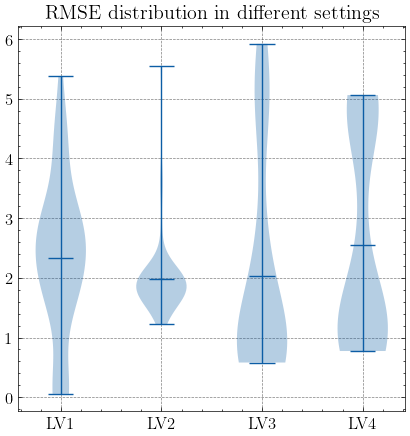

In [41]:
fig = plt.figure(figsize=(5, 5))
plt.violinplot(
    [lv1['rmse'].to_numpy(), lv2['rmse'].to_numpy(), lv3['rmse'].to_numpy(), lv4['rmse'].to_numpy()],
    showextrema=True, showmeans=True
)

plt.title('RMSE distribution in different settings')
plt.xticks(ticks=[1, 2, 3, 4], labels=['LV1', 'LV2', 'LV3', 'LV4'])
plt.plot()

Instances of group...
eye - 35
normal - 8
zeros - 7


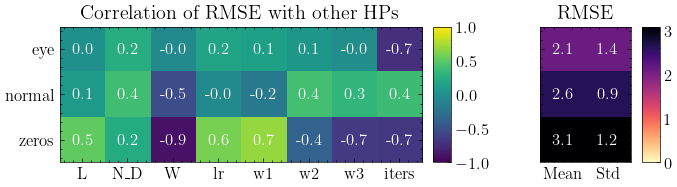

In [7]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv1)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

Instances of group...
eye - 22
normal - 18
zeros - 10


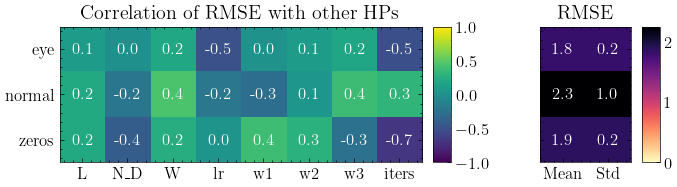

In [8]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv2)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

Instances of group...
eye - 7
normal - 36
zeros - 7


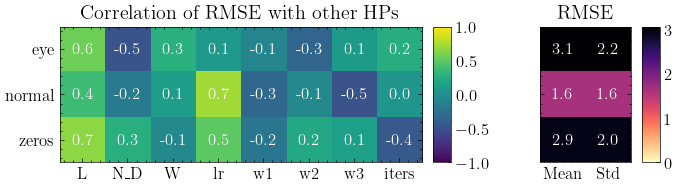

In [9]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv3)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)

Instances of group...
eye - 7
normal - 34
zeros - 9


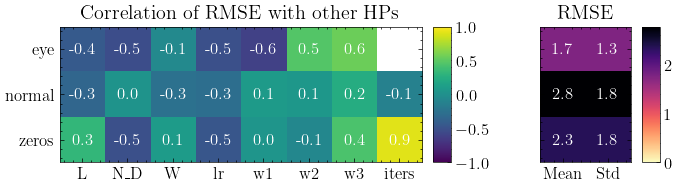

In [10]:
correlation, rmse_data, xlabels, ylabels = get_corr(lv4)
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels)